In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# --- ML Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, BatchNormalization,
                                     Dropout, Dense, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_ROWS, IMG_COLS = 28, 28
NUM_CLASSES = 10
BATCH_SIZE = 256
EPOCHS = 50
VAL_SPLIT = 0.2
RANDOM_STATE = 42
CLASS_NAMES = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
               4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker",
               8: "Bag", 9: "Ankle Boot"}

In [ ]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU Available: []


In [ ]:
def load_data():
    train = pd.read_csv('/content/fashion-mnist_train.csv')
    test = pd.read_csv('/content/fashion-mnist_test.csv')
    return train, test

train_df, test_df = load_data()

In [ ]:
# --- Data Integrity Checks ---
print("\n=== Data Integrity Report ===")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Missing values in train: {train_df.isnull().sum().sum()}")
print(f"Missing values in test: {test_df.isnull().sum().sum()}")
print(f"Pixel value range: [{train_df.iloc[:,1:].min().min()}, {train_df.iloc[:,1:].max().max()}]")



=== Data Integrity Report ===
Training samples: 60000
Test samples: 10000
Missing values in train: 0
Missing values in test: 0
Pixel value range: [0, 255]


In [ ]:
# --- Class Distribution Analysis ---
def plot_class_distribution(df, title):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x='label', data=df, palette="viridis")
    plt.title(title, fontsize=14)
    plt.xticks(ticks=np.arange(10), labels=CLASS_NAMES.values(), rotation=45)

    # Add percentage annotations
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 50,
                f'{height/total:.1%}', ha='center')
    plt.show()

<ipython-input-6-aab65860ad47>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette="viridis")


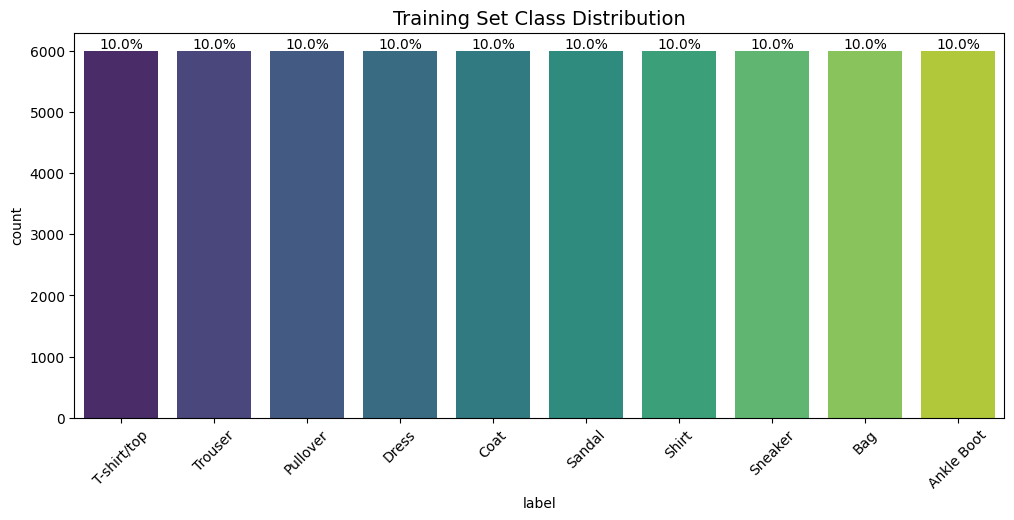

<ipython-input-6-aab65860ad47>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette="viridis")


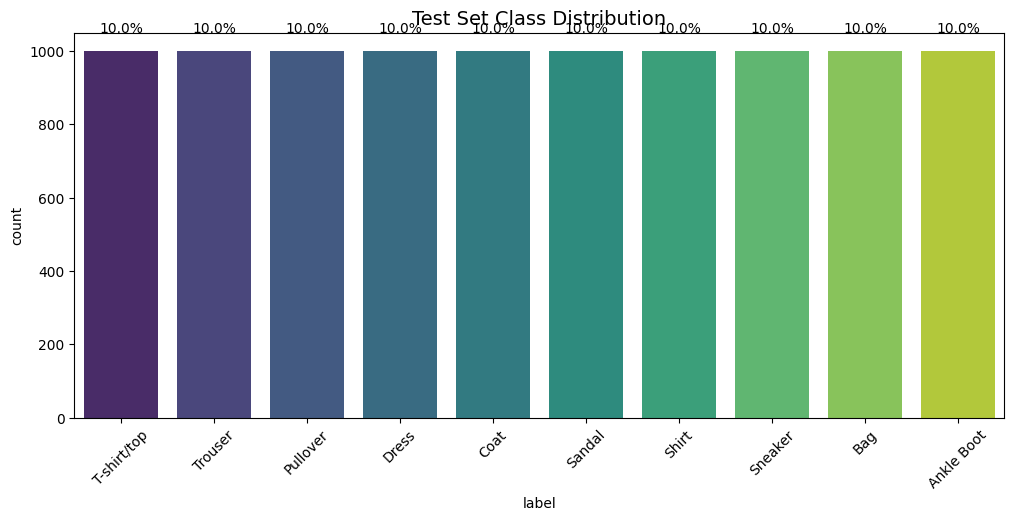

In [ ]:
plot_class_distribution(train_df, "Training Set Class Distribution")
plot_class_distribution(test_df, "Test Set Class Distribution")

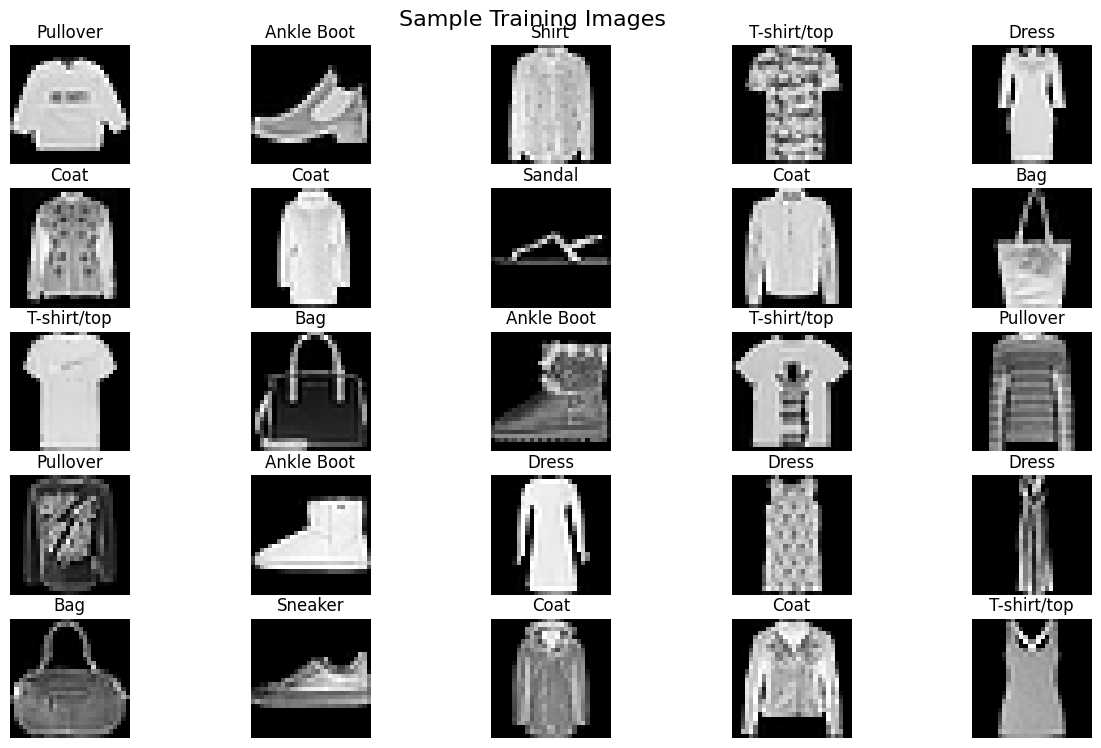

In [ ]:
# --- Sample Image Visualization ---
plt.figure(figsize=(15,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_df.iloc[i,1:].values.reshape(28,28), cmap='gray')
    plt.title(CLASS_NAMES[train_df.label[i]])
    plt.axis('off')
plt.suptitle("Sample Training Images", y=0.92, fontsize=16)
plt.show()

In [ ]:
# 3. Data Preprocessing
# ==========================
# --- Data Preparation ---
def prepare_data(df):
    X = df.drop('label', axis=1).values.astype('float32') / 255.0
    y = to_categorical(df['label'].values, NUM_CLASSES)
    return X.reshape(-1, IMG_ROWS, IMG_COLS, 1), y

In [ ]:
X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

In [ ]:
# Stratified Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y_train
)

print("\n=== Processed Data Shapes ===")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


=== Processed Data Shapes ===
Train: (48000, 28, 28, 1), (48000, 10)
Validation: (12000, 28, 28, 1), (12000, 10)
Test: (10000, 28, 28, 1), (10000, 10)


In [ ]:
# --- Advanced Data Augmentation ---
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.15,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.0  # Fill missing pixels with black
)

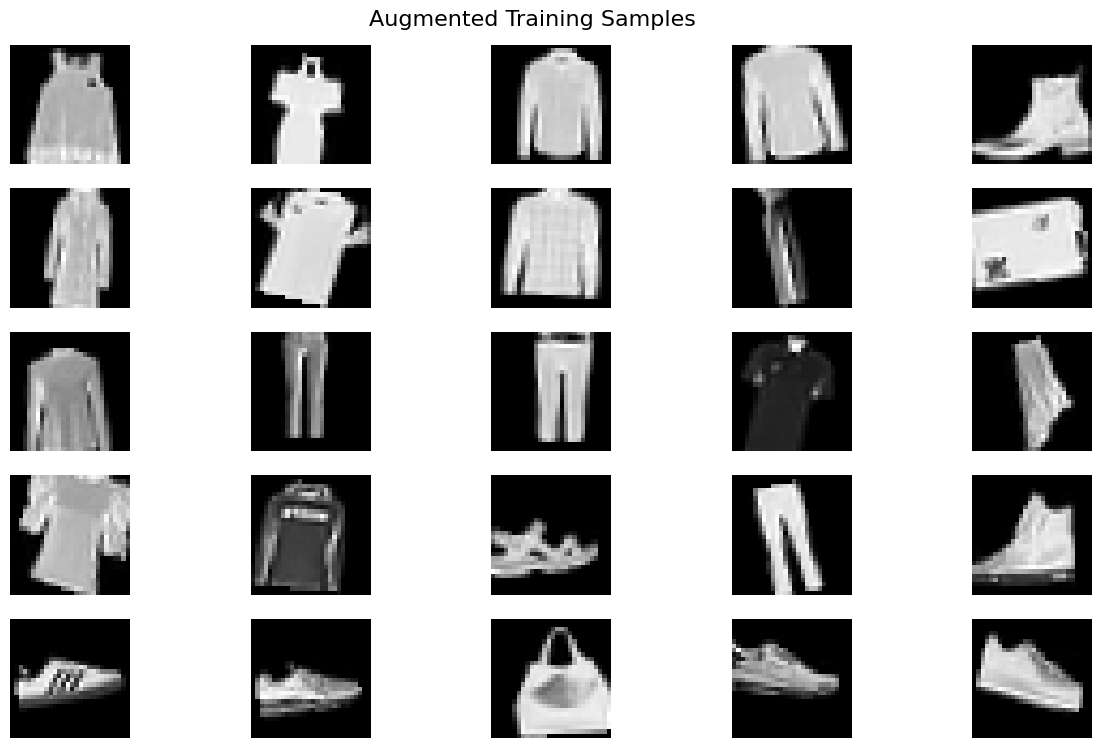

In [ ]:
# Visualize Augmentation Effects
sample_batch = next(augmenter.flow(X_train[:25], shuffle=False))
plt.figure(figsize=(15,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(sample_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Training Samples", y=0.92, fontsize=16)
plt.show()

In [ ]:
# 4. Model Architecture
# ==========================
def build_advanced_cnn():
    model = Sequential([
        # Block 1
        Conv2D(64, (3,3), activation='relu', padding='same',
               input_shape=(IMG_ROWS, IMG_COLS, 1)),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(2,2),
        Dropout(0.3),

        # Block 2
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(2,2),
        Dropout(0.4),

        # Classifier Head
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc')])
    return model

model = build_advanced_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,479,498 (13.27 MB)

 Trainable params: 3,477,706 (13.27 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# 5. Model Training
# ==========================
# --- Training Callbacks ---
callbacks = [
    EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_auc',
                    mode='max', save_best_only=True, verbose=1)
]


In [ ]:
# --- Training Execution ---
history = model.fit(
    augmenter.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6272 - auc: 0.9257 - loss: 1.1948 - precision: 0.6827 - recall: 0.5770
Epoch 1: val_auc improved from -inf to 0.63982, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 803s 4s/step - accuracy: 0.6276 - auc: 0.9259 - loss: 1.1931 - precision: 0.6831 - recall: 0.5774 - val_accuracy: 0.2702 - val_auc: 0.6398 - val_loss: 3.0284 - val_precision: 0.4781 - val_recall: 0.1383 - learning_rate: 0.0010
Epoch 2/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 14:56 5s/step - accuracy: 0.7695 - auc: 0.9806 - loss: 0.5970 - precision: 0.8106 - recall: 0.7188

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc improved from 0.63982 to 0.64018, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 221ms/step - accuracy: 0.7695 - auc: 0.9806 - loss: 0.5970 - precision: 0.8106 - recall: 0.7188 - val_accuracy: 0.2779 - val_auc: 0.6402 - val_loss: 3.0203 - val_precision: 0.4825 - val_recall: 0.1422 - learning_rate: 0.0010
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7918 - auc: 0.9800 - loss: 0.5742 - precision: 0.8381 - recall: 0.7471
Epoch 3: val_auc improved from 0.64018 to 0.81857, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 778s 4s/step - accuracy: 0.7918 - auc: 0.9800 - loss: 0.5741 - precision: 0.8382 - recall: 0.7471 - val_accuracy: 0.4493 - val_auc: 0.8186 - val_loss: 2.1571 - val_precision: 0.5198 - val_recall: 0.4354 - learning_rate: 0.0010
Epoch 4/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12:50 4s/step - accuracy: 0.8203 - auc: 0.9848 - loss: 0.4727 - precision: 0.8686 - recall: 0.8008
Epoch 4: val_auc did not improve from 0.81857
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.8203 - auc: 0.9848 - loss: 0.4727 - precision: 0.8686 - recall: 0.8008 - val_accuracy: 0.4492 - val_auc: 0.8178 - val_loss: 2.1924 - val_precision: 0.5060 - val_recall: 0.4363 - learning_rate: 0.0010
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8137 - auc: 0.9846 - loss: 0.4996 - precision: 0.8536 - recall: 0.7755
Epoch 5: val_auc improved from 0.81857 to 0.97461, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 755s 4s/step - accuracy: 0.8137 - auc: 0.9846 - loss: 0.4996 - precision: 0.8536 - recall: 0.7755 - val_accuracy: 0.7338 - val_auc: 0.9746 - val_loss: 0.6767 - val_precision: 0.7697 - val_recall: 0.6976 - learning_rate: 0.0010
Epoch 6/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:44 3s/step - accuracy: 0.8320 - auc: 0.9888 - loss: 0.4454 - precision: 0.8707 - recall: 0.7891
Epoch 6: val_auc improved from 0.97461 to 0.97631, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - accuracy: 0.8320 - auc: 0.9888 - loss: 0.4454 - precision: 0.8707 - recall: 0.7891 - val_accuracy: 0.7423 - val_auc: 0.9763 - val_loss: 0.6486 - val_precision: 0.7814 - val_recall: 0.7041 - learning_rate: 0.0010
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8341 - auc: 0.9877 - loss: 0.4441 - precision: 0.8710 - recall: 0.8005
Epoch 7: val_auc improved from 0.97631 to 0.99280, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.8341 - auc: 0.9877 - loss: 0.4441 - precision: 0.8710 - recall: 0.8006 - val_accuracy: 0.8787 - val_auc: 0.9928 - val_loss: 0.3250 - val_precision: 0.8965 - val_recall: 0.8620 - learning_rate: 0.0010
Epoch 8/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 13:50 4s/step - accuracy: 0.8477 - auc: 0.9907 - loss: 0.4060 - precision: 0.8708 - recall: 0.8164
Epoch 8: val_auc improved from 0.99280 to 0.99281, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 221ms/step - accuracy: 0.8477 - auc: 0.9907 - loss: 0.4060 - precision: 0.8708 - recall: 0.8164 - val_accuracy: 0.8787 - val_auc: 0.9928 - val_loss: 0.3247 - val_precision: 0.8967 - val_recall: 0.8626 - learning_rate: 0.0010
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8470 - auc: 0.9891 - loss: 0.4134 - precision: 0.8776 - recall: 0.8176
Epoch 9: val_auc improved from 0.99281 to 0.99334, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.8470 - auc: 0.9891 - loss: 0.4133 - precision: 0.8777 - recall: 0.8176 - val_accuracy: 0.8882 - val_auc: 0.9933 - val_loss: 0.3073 - val_precision: 0.9047 - val_recall: 0.8737 - learning_rate: 0.0010
Epoch 10/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:17 3s/step - accuracy: 0.8555 - auc: 0.9913 - loss: 0.3904 - precision: 0.8782 - recall: 0.8164
Epoch 10: val_auc improved from 0.99334 to 0.99356, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 0.8555 - auc: 0.9913 - loss: 0.3904 - precision: 0.8782 - recall: 0.8164 - val_accuracy: 0.8864 - val_auc: 0.9936 - val_loss: 0.3072 - val_precision: 0.9039 - val_recall: 0.8714 - learning_rate: 0.0010
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8539 - auc: 0.9898 - loss: 0.3951 - precision: 0.8838 - recall: 0.8286
Epoch 11: val_auc did not improve from 0.99356
187/187 ━━━━━━━━━━━━━━━━━━━━ 819s 4s/step - accuracy: 0.8539 - auc: 0.9898 - loss: 0.3951 - precision: 0.8838 - recall: 0.8286 - val_accuracy: 0.8773 - val_auc: 0.9931 - val_loss: 0.3202 - val_precision: 0.8955 - val_recall: 0.8637 - learning_rate: 0.0010
Epoch 12/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:37 3s/step - accuracy: 0.8633 - auc: 0.9945 - loss: 0.3196 - precision: 0.9106 - recall: 0.8359
Epoch 12: val_auc did not improve from 0.99356
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - accuracy: 0.8633 - auc: 0.9945 - loss: 0.3196 - precision: 0.9106 - r

187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.8711 - auc: 0.9913 - loss: 0.3486 - precision: 0.9004 - recall: 0.8477 - val_accuracy: 0.8872 - val_auc: 0.9937 - val_loss: 0.3020 - val_precision: 0.9057 - val_recall: 0.8695 - learning_rate: 0.0010
Epoch 15/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8692 - auc: 0.9913 - loss: 0.3610 - precision: 0.8944 - recall: 0.8444
Epoch 15: val_auc improved from 0.99370 to 0.99371, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 0.8692 - auc: 0.9913 - loss: 0.3609 - precision: 0.8944 - recall: 0.8444 - val_accuracy: 0.8814 - val_auc: 0.9937 - val_loss: 0.3044 - val_precision: 0.8951 - val_recall: 0.8691 - learning_rate: 0.0010
Epoch 16/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 12:48 4s/step - accuracy: 0.8750 - auc: 0.9895 - loss: 0.3716 - precision: 0.8852 - recall: 0.8438
Epoch 16: val_auc did not improve from 0.99371
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.8750 - auc: 0.9895 - loss: 0.3716 - precision: 0.8852 - recall: 0.8438 - val_accuracy: 0.8824 - val_auc: 0.9937 - val_loss: 0.3039 - val_precision: 0.8964 - val_recall: 0.8698 - learning_rate: 0.0010
Epoch 17/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8776 - auc: 0.9925 - loss: 0.3351 - precision: 0.9007 - recall: 0.8574
Epoch 17: val_auc improved from 0.99371 to 0.99506, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.8776 - auc: 0.9925 - loss: 0.3351 - precision: 0.9007 - recall: 0.8574 - val_accuracy: 0.9002 - val_auc: 0.9951 - val_loss: 0.2676 - val_precision: 0.9175 - val_recall: 0.8838 - learning_rate: 0.0010
Epoch 18/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:21 3s/step - accuracy: 0.8750 - auc: 0.9917 - loss: 0.3862 - precision: 0.8934 - recall: 0.8516
Epoch 18: val_auc improved from 0.99506 to 0.99524, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy: 0.8750 - auc: 0.9917 - loss: 0.3862 - precision: 0.8934 - recall: 0.8516 - val_accuracy: 0.9016 - val_auc: 0.9952 - val_loss: 0.2635 - val_precision: 0.9195 - val_recall: 0.8857 - learning_rate: 0.0010
Epoch 19/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8764 - auc: 0.9924 - loss: 0.3368 - precision: 0.9004 - recall: 0.8548
Epoch 19: val_auc did not improve from 0.99524
187/187 ━━━━━━━━━━━━━━━━━━━━ 758s 4s/step - accuracy: 0.8764 - auc: 0.9924 - loss: 0.3367 - precision: 0.9004 - recall: 0.8548 - val_accuracy: 0.9003 - val_auc: 0.9945 - val_loss: 0.2692 - val_precision: 0.9116 - val_recall: 0.8886 - learning_rate: 0.0010
Epoch 20/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:03 3s/step - accuracy: 0.8867 - auc: 0.9952 - loss: 0.2882 - precision: 0.8960 - recall: 0.8750
Epoch 20: val_auc did not improve from 0.99524
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - accuracy: 0.8867 - auc: 0.9952 - loss: 0.2882 - precision: 0.8960 - r

187/187 ━━━━━━━━━━━━━━━━━━━━ 759s 4s/step - accuracy: 0.8811 - auc: 0.9930 - loss: 0.3197 - precision: 0.9020 - recall: 0.8626 - val_accuracy: 0.9039 - val_auc: 0.9954 - val_loss: 0.2499 - val_precision: 0.9192 - val_recall: 0.8926 - learning_rate: 0.0010
Epoch 24/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:18 3s/step - accuracy: 0.9062 - auc: 0.9941 - loss: 0.2838 - precision: 0.9259 - recall: 0.8789
Epoch 24: val_auc improved from 0.99545 to 0.99549, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy: 0.9062 - auc: 0.9941 - loss: 0.2838 - precision: 0.9259 - recall: 0.8789 - val_accuracy: 0.9060 - val_auc: 0.9955 - val_loss: 0.2480 - val_precision: 0.9205 - val_recall: 0.8930 - learning_rate: 0.0010
Epoch 25/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8853 - auc: 0.9937 - loss: 0.3069 - precision: 0.9061 - recall: 0.8684
Epoch 25: val_auc did not improve from 0.99549
187/187 ━━━━━━━━━━━━━━━━━━━━ 764s 4s/step - accuracy: 0.8853 - auc: 0.9937 - loss: 0.3069 - precision: 0.9061 - recall: 0.8684 - val_accuracy: 0.8896 - val_auc: 0.9940 - val_loss: 0.2866 - val_precision: 0.9041 - val_recall: 0.8788 - learning_rate: 0.0010
Epoch 26/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 13:36 4s/step - accuracy: 0.9062 - auc: 0.9935 - loss: 0.2956 - precision: 0.9184 - recall: 0.8789
Epoch 26: val_auc did not improve from 0.99549
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.9062 - auc: 0.9935 - loss: 0.2956 - precision: 0.9184 - r

187/187 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.8959 - auc: 0.9946 - loss: 0.2817 - precision: 0.9156 - recall: 0.8790 - val_accuracy: 0.9080 - val_auc: 0.9960 - val_loss: 0.2431 - val_precision: 0.9196 - val_recall: 0.8962 - learning_rate: 2.0000e-04
Epoch 32/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:24 3s/step - accuracy: 0.8750 - auc: 0.9925 - loss: 0.3220 - precision: 0.8971 - recall: 0.8516
Epoch 32: val_auc improved from 0.99599 to 0.99602, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy: 0.8750 - auc: 0.9925 - loss: 0.3220 - precision: 0.8971 - recall: 0.8516 - val_accuracy: 0.9079 - val_auc: 0.9960 - val_loss: 0.2420 - val_precision: 0.9199 - val_recall: 0.8969 - learning_rate: 2.0000e-04
Epoch 33/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9025 - auc: 0.9951 - loss: 0.2619 - precision: 0.9213 - recall: 0.8878
Epoch 33: val_auc improved from 0.99602 to 0.99656, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 0.9025 - auc: 0.9951 - loss: 0.2619 - precision: 0.9213 - recall: 0.8878 - val_accuracy: 0.9180 - val_auc: 0.9966 - val_loss: 0.2181 - val_precision: 0.9289 - val_recall: 0.9094 - learning_rate: 2.0000e-04
Epoch 34/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 11:28 4s/step - accuracy: 0.9102 - auc: 0.9945 - loss: 0.2548 - precision: 0.9234 - recall: 0.8945
Epoch 34: val_auc did not improve from 0.99656
187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.9102 - auc: 0.9945 - loss: 0.2548 - precision: 0.9234 - recall: 0.8945 - val_accuracy: 0.9178 - val_auc: 0.9965 - val_loss: 0.2191 - val_precision: 0.9286 - val_recall: 0.9087 - learning_rate: 2.0000e-04
Epoch 35/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9054 - auc: 0.9950 - loss: 0.2615 - precision: 0.9211 - recall: 0.8890
Epoch 35: val_auc did not improve from 0.99656
187/187 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.9054 - auc: 0.9950 - loss: 0.2615 - precision: 0.92

187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy: 0.9102 - auc: 0.9961 - loss: 0.2597 - precision: 0.9259 - recall: 0.8789 - val_accuracy: 0.9190 - val_auc: 0.9966 - val_loss: 0.2150 - val_precision: 0.9312 - val_recall: 0.9097 - learning_rate: 2.0000e-04
Epoch 37/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9072 - auc: 0.9951 - loss: 0.2556 - precision: 0.9233 - recall: 0.8933
Epoch 37: val_auc improved from 0.99664 to 0.99682, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 748s 4s/step - accuracy: 0.9072 - auc: 0.9951 - loss: 0.2556 - precision: 0.9233 - recall: 0.8933 - val_accuracy: 0.9220 - val_auc: 0.9968 - val_loss: 0.2102 - val_precision: 0.9322 - val_recall: 0.9129 - learning_rate: 2.0000e-04
Epoch 38/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - accuracy: 0.9180 - auc: 0.9922 - loss: 0.2788 - precision: 0.9283 - recall: 0.9102
Epoch 38: val_auc improved from 0.99682 to 0.99685, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.9180 - auc: 0.9922 - loss: 0.2788 - precision: 0.9283 - recall: 0.9102 - val_accuracy: 0.9225 - val_auc: 0.9969 - val_loss: 0.2089 - val_precision: 0.9322 - val_recall: 0.9137 - learning_rate: 2.0000e-04
Epoch 39/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9056 - auc: 0.9951 - loss: 0.2555 - precision: 0.9208 - recall: 0.8921
Epoch 39: val_auc improved from 0.99685 to 0.99691, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.9056 - auc: 0.9951 - loss: 0.2555 - precision: 0.9208 - recall: 0.8921 - val_accuracy: 0.9233 - val_auc: 0.9969 - val_loss: 0.2057 - val_precision: 0.9349 - val_recall: 0.9137 - learning_rate: 2.0000e-04
Epoch 40/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:24 3s/step - accuracy: 0.9219 - auc: 0.9932 - loss: 0.3019 - precision: 0.9312 - recall: 0.8984
Epoch 40: val_auc improved from 0.99691 to 0.99691, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 45s 222ms/step - accuracy: 0.9219 - auc: 0.9932 - loss: 0.3019 - precision: 0.9312 - recall: 0.8984 - val_accuracy: 0.9233 - val_auc: 0.9969 - val_loss: 0.2056 - val_precision: 0.9349 - val_recall: 0.9143 - learning_rate: 2.0000e-04
Epoch 41/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9083 - auc: 0.9957 - loss: 0.2483 - precision: 0.9232 - recall: 0.8956
Epoch 41: val_auc did not improve from 0.99691
187/187 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.9083 - auc: 0.9957 - loss: 0.2483 - precision: 0.9233 - recall: 0.8956 - val_accuracy: 0.9216 - val_auc: 0.9967 - val_loss: 0.2104 - val_precision: 0.9331 - val_recall: 0.9129 - learning_rate: 2.0000e-04
Epoch 42/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:34 3s/step - accuracy: 0.9180 - auc: 0.9945 - loss: 0.2595 - precision: 0.9315 - recall: 0.9023
Epoch 42: val_auc did not improve from 0.99691
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - accuracy: 0.9180 - auc: 0.9945 - loss: 0.2595 - precision: 0.

187/187 ━━━━━━━━━━━━━━━━━━━━ 762s 4s/step - accuracy: 0.9102 - auc: 0.9957 - loss: 0.2442 - precision: 0.9240 - recall: 0.8965 - val_accuracy: 0.9237 - val_auc: 0.9970 - val_loss: 0.2027 - val_precision: 0.9350 - val_recall: 0.9160 - learning_rate: 2.0000e-04
Epoch 46/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:00 3s/step - accuracy: 0.8906 - auc: 0.9935 - loss: 0.2934 - precision: 0.9109 - recall: 0.8789
Epoch 46: val_auc improved from 0.99697 to 0.99701, saving model to best_model.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - accuracy: 0.8906 - auc: 0.9935 - loss: 0.2934 - precision: 0.9109 - recall: 0.8789 - val_accuracy: 0.9237 - val_auc: 0.9970 - val_loss: 0.2024 - val_precision: 0.9346 - val_recall: 0.9165 - learning_rate: 2.0000e-04
Epoch 47/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9087 - auc: 0.9957 - loss: 0.2469 - precision: 0.9239 - recall: 0.8948
Epoch 47: val_auc did not improve from 0.99701
187/187 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.9087 - auc: 0.9957 - loss: 0.2469 - precision: 0.9239 - recall: 0.8948 - val_accuracy: 0.9197 - val_auc: 0.9965 - val_loss: 0.2169 - val_precision: 0.9305 - val_recall: 0.9115 - learning_rate: 2.0000e-04
Epoch 48/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 10:05 3s/step - accuracy: 0.9258 - auc: 0.9949 - loss: 0.2361 - precision: 0.9357 - recall: 0.9102
Epoch 48: val_auc did not improve from 0.99701
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.9258 - auc: 0.9949 - loss: 0.2361 - precision: 0.

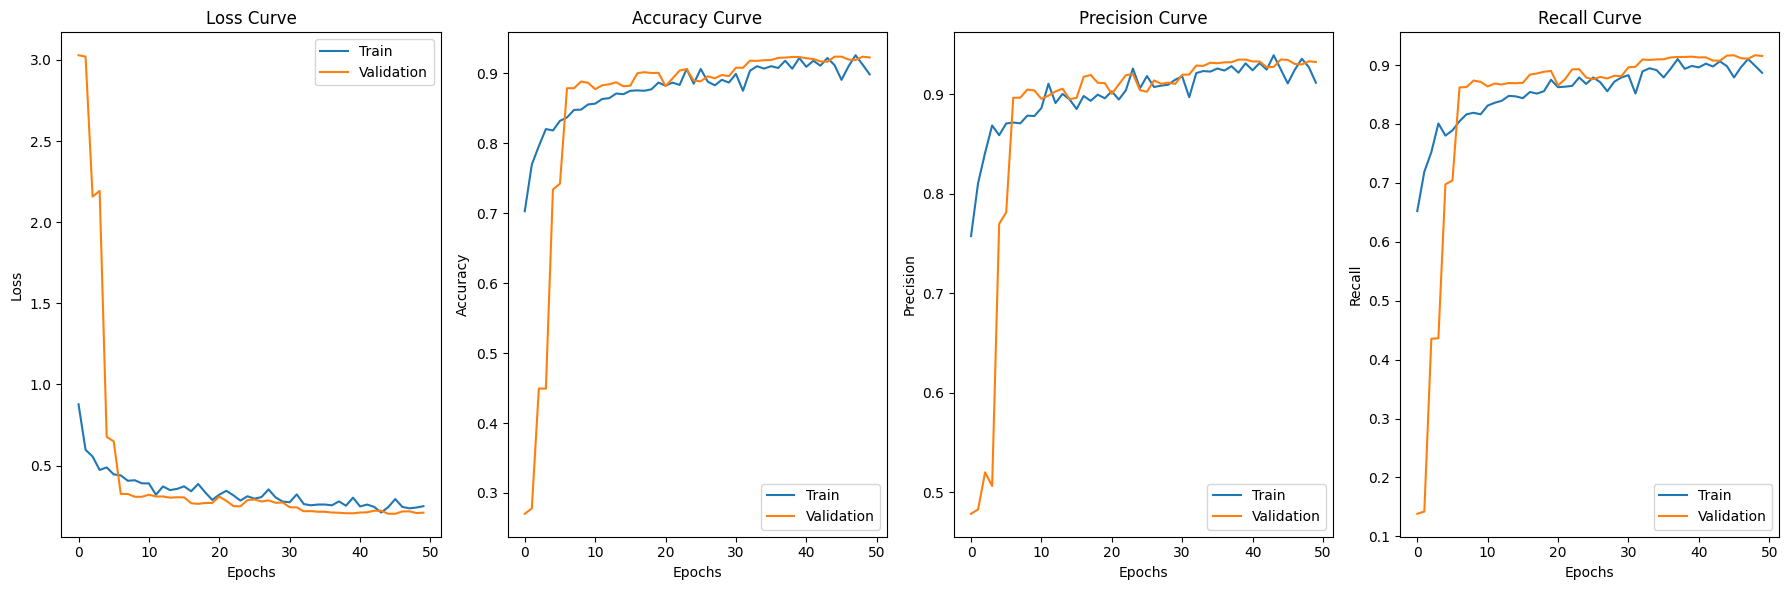

In [17]:
# 6. Model Evaluation
# ==========================
# --- Training Metrics Visualization ---

def plot_training_metrics(history):
    plt.figure(figsize=(18, 6))
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 4, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'{metric.title()} Curve')
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_metrics(history)

=== Final Test Metrics ===
Loss: 0.1961
Accuracy: 0.9292
Precision: 0.9396
Recall: 0.9194
AUC: 0.9969
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.86      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.95      0.86      0.90      1000
       Dress       0.95      0.90      0.93      1000
        Coat       0.90      0.88      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.73      0.86      0.79      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.98      1.00      0.99      1000
  Ankle Boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



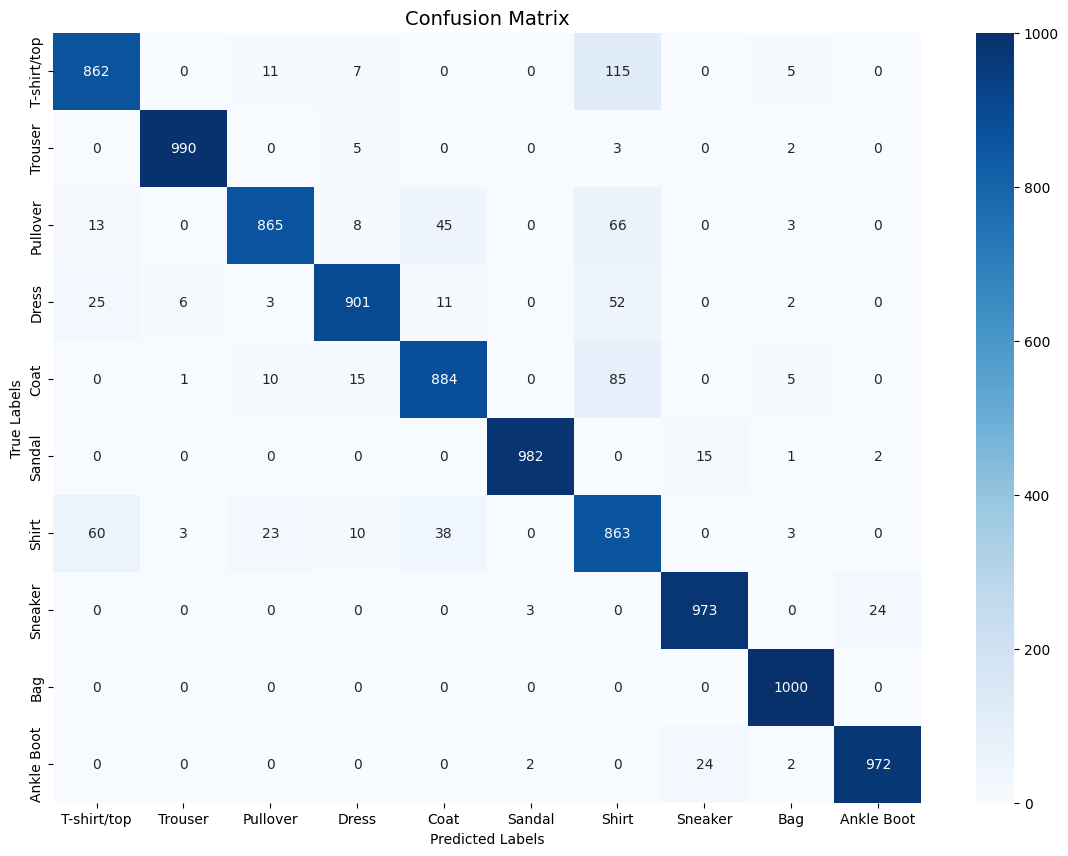

In [22]:
# --- Comprehensive Test Evaluation ---
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print("=== Final Test Metrics ===")
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Precision: {results[2]:.4f}")
    print(f"Recall: {results[3]:.4f}")
    print(f"AUC: {results[4]:.4f}")

    # Classification Report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes,
                                target_names=CLASS_NAMES.values()))

     # Confusion Matrix
    plt.figure(figsize=(14,10))
    sns.heatmap(confusion_matrix(y_true, y_pred_classes),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES.values(),
                yticklabels=CLASS_NAMES.values())
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

evaluate_model(model, X_test, y_test)

In [23]:
# --- Error Analysis ---
errors = np.where(np.argmax(y_test, axis=1) != np.argmax(model.predict(X_test), axis=1))[0]
print(f"\nNumber of misclassified samples: {len(errors)}/{len(X_test)} ({len(errors)/len(X_test):.2%})")

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step

Number of misclassified samples: 708/10000 (7.08%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


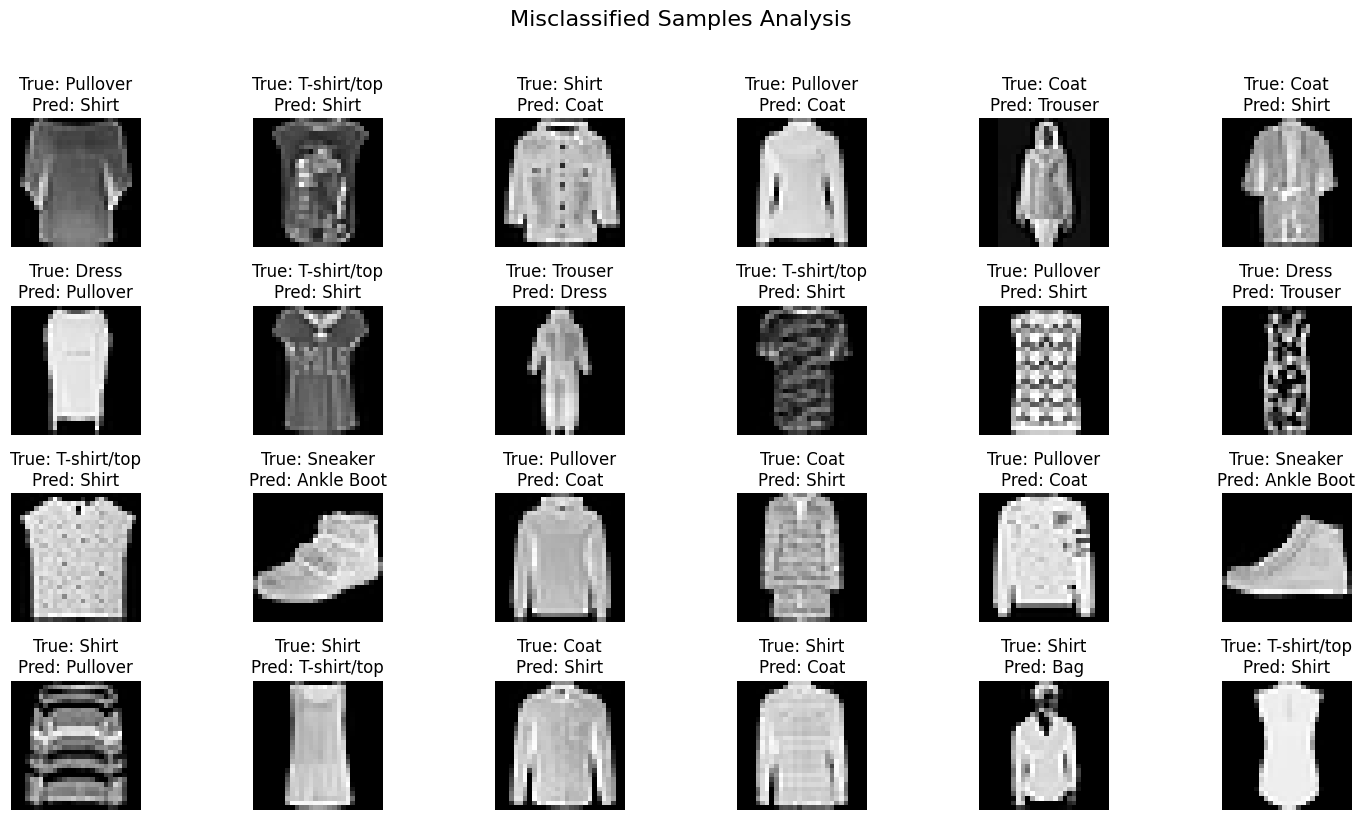

In [24]:
plt.figure(figsize=(15,8))
for i in range(24):
    idx = errors[i]
    plt.subplot(4,6,i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {CLASS_NAMES[np.argmax(y_test[idx])]}\nPred: {CLASS_NAMES[np.argmax(model.predict(X_test[idx:idx+1]))]}")
    plt.axis('off')
plt.suptitle("Misclassified Samples Analysis", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

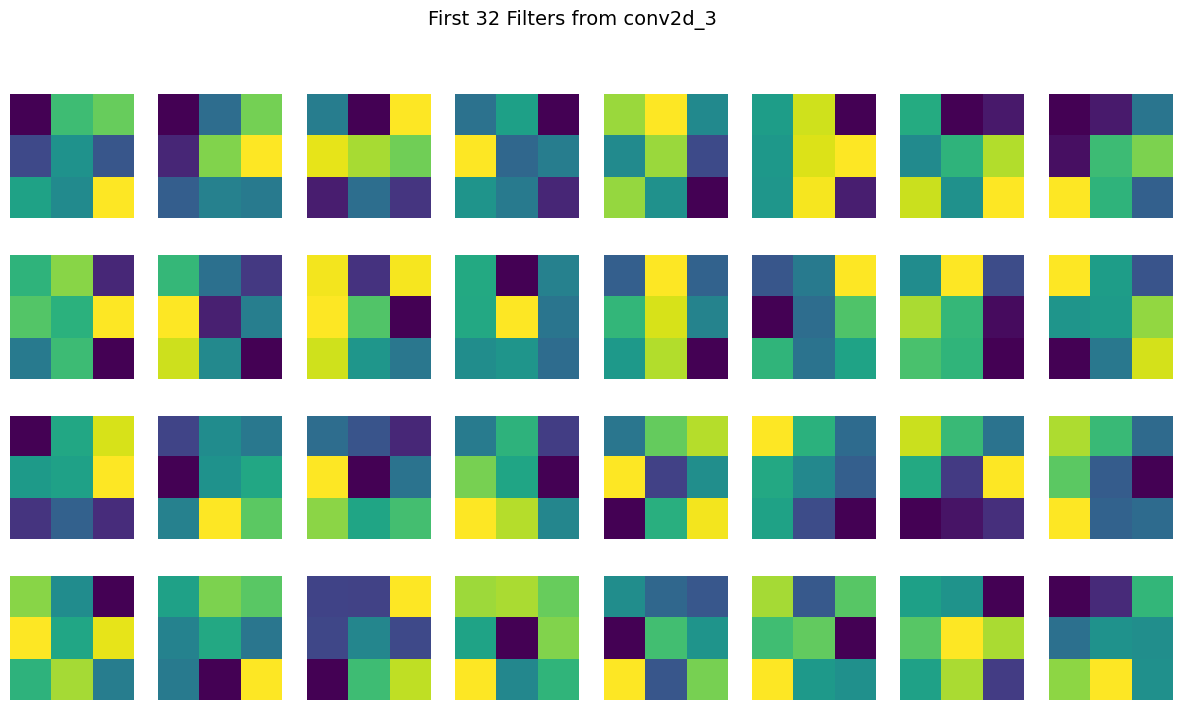

In [25]:
# 7. Model Interpretation
# ==========================
# --- Feature Visualization ---
def visualize_filters(layer_name='conv2d_3'):
    layer = model.get_layer(layer_name)
    filters = layer.get_weights()[0]

    plt.figure(figsize=(15,8))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(filters[:,:,0,i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"First 32 Filters from {layer_name}", fontsize=14)
    plt.show()

visualize_filters()

In [27]:
# 7. Advanced Model Interpretation
# ==========================
# --- Grad-CAM Implementation ---
def generate_grad_cam(model, img_array, layer_name='conv2d_3'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)
    return heatmap


In [33]:
# 7. Enhanced Model Interpretation
# ==========================
# --- Fixed Grad-CAM Implementation ---
def generate_grad_cam(model, img_array, layer_name='conv2d_3'):
    # Create gradient model with original model inputs and outputs
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    # Calculate gradients and pooled gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate heatmap
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [30]:
# --- Verified Layer Name Check ---
print("\nAvailable CNN Layers:")
for idx, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        print(f"Layer {idx}: {layer.name}")

# --- Robust Visualization Implementation ---
def visualize_gradcam(samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(samples):
        idx = errors[i]
        img = X_test[idx]
        heatmap = generate_grad_cam(model, np.expand_dims(img, 0))

        # Original Image
        plt.subplot(2, samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {CLASS_NAMES[np.argmax(y_test[idx])]}")
        plt.axis('off')

        # Heatmap Overlay
        plt.subplot(2, samples, i+1+samples)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(heatmap, alpha=0.6, cmap='jet')
        plt.title(f"Pred: {CLASS_NAMES[np.argmax(model.predict(img[np.newaxis,...]))]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()




Available CNN Layers:
Layer 0: conv2d
Layer 2: conv2d_1
Layer 6: conv2d_2
Layer 8: conv2d_3


In [36]:
model.save('CNN Fashion MNIST Object Detection using Keras.h5')
print("\n✅ Model saved for production deployment")


✅ Model saved for production deployment


#**Conclusion**

With a complex sequential model with multiple convolution layers and 50 epochs for the training, we obtained an accuracy ~0.91 for test prediction, showing strong features extraction capabailities for fashion items through its convolutional layers. After investigating the validation accuracy and loss, we understood that the model is overfitting. Moderate overfitting indicates potential for regularization improvements


We retrained the model with Dropout layers to the model to reduce overfitting.
We confirmed the model improvement and with the same number of epochs for the training we obtained with the new model an accuracy of ~0.93 for test prediction. Shirts (class 6) show the lowest recall (0.82), frequently confused with T-shirts/tops and Pullovers. Shirts (class 6) show the lowest recall (0.82), frequently confused with T-shirts/tops and Pullovers. Model size (trainable params: 227,146) is reasonable for edge deployment


While training plateaus after ~25 epochs, suggesting early stopping could save computation



